In [ ]:
cfrom google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
# Other tools
import time
import os
import copy

from torchsummary import summary

env: OMP_NUM_THREADS=1


In [ ]:
# Pennylane python -m
!pip install pennylane
#pip install pennylane --upgrade


In [ ]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

In [ ]:
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004 #0.0001                    # Learning rate 0.0001 means 50%
batch_size = 4 #2                   # Number of samples for each training step 8 around 87% 2 means 50%
num_epochs = 20               # Number of training epochs
q_depth = 8                     # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

Let us initialize a PennyLane device with the default simulator.


In [ ]:
dev = qml.device('default.qubit', wires=n_qubits)



Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Dataset loading**

In [ ]:
data_transforms = {
    'training': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/New_dataset_normal_DRUSEN'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['training', 'testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
class_names = image_datasets['training'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['training', 'testing']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
print(dataset_sizes)

{'training': 400, 'testing': 100}


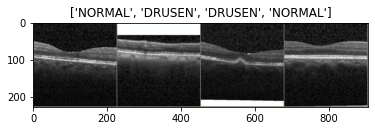

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['testing']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
torchvision.utils.save_image(out, 'test.png', dpi=300)

In [ ]:
print(classes)

tensor([1, 0, 0, 1])


In [ ]:

torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['training', 'testing']}

In [ ]:
print(type(dataloaders))

<class 'dict'>


Hybrid transfer learning model (classical-to-quantum).


In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [ ]:
class Quantumnet(nn.Module):    
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, 4)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
  
    model_hybrid.fc = Quantumnet()
    print(type(model_hybrid.fc))
    
elif classical_model == '512_2':
    model_hybrid.fc = nn.Linear(512, 2)
    
elif classical_model == '512_nq_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '551_512_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

<class '__main__.Quantumnet'>


Training and results


In [ ]:
criterion = nn.CrossEntropyLoss()


In [ ]:

optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [ ]:

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [ ]:

eval_accu1=[]
nb_classes = 4
confusion_matrix = torch.zeros(nb_classes, nb_classes)
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        
        for epoch in range(num_epochs):    
            
            # Each epoch has a training and validation phase
            for phase in ['training', 'testing']:
                if phase == 'training':
                    scheduler.step()
                    # Set model to training mode
                    model.train()  
                else:
                    # Set model to evaluate mode
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'training'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        for t, p in zip(labels.view(-1), preds.view(-1)):
                          confusion_matrix[t.long(), p.long()] += 1
                        loss = criterion(outputs, labels)
                        if phase == 'training':
                            loss.backward()
                            optimizer.step()
                    
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                eval_accu1.append(epoch_acc)
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('training' if phase == 'training' else 'testing ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'testing' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'training' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'training' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results           
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=20)

Training started:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Phase: training Epoch: 1/20 Loss: 1.0271 Acc: 0.5650        
Phase: testing  Epoch: 1/20 Loss: 0.9665 Acc: 0.6700        
Phase: training Epoch: 2/20 Loss: 0.9329 Acc: 0.6500        
Phase: testing  Epoch: 2/20 Loss: 0.9102 Acc: 0.6100        
Phase: training Epoch: 3/20 Loss: 0.8540 Acc: 0.7075        
Phase: testing  Epoch: 3/20 Loss: 0.8311 Acc: 0.7000        
Phase: training Epoch: 4/20 Loss: 0.7929 Acc: 0.7700        
Phase: testing  Epoch: 4/20 Loss: 0.7653 Acc: 0.7600        
Phase: training Epoch: 5/20 Loss: 0.7330 Acc: 0.7975        
Phase: testing  Epoch: 5/20 Loss: 0.7379 Acc: 0.7300        
Phase: training Epoch: 6/20 Loss: 0.7175 Acc: 0.7450        
Phase: testing  Epoch: 6/20 Loss: 0.6877 Acc: 0.7800        
Phase: training Epoch: 7/20 Loss: 0.6550 Acc: 0.8300        
Phase: testing  Epoch: 7/20 Loss: 0.6542 Acc: 0.8000        
Phase: training Epoch: 8/20 Loss: 0.6556 Acc: 0.7800        
Phase: testing  Epoch: 8/20 Loss: 0.6231 Acc: 0.8000        
Phase: training Epoch: 9

In [ ]:
if quantum:
        torch.save(model_hybrid.state_dict(), "quantum_oct.pt")
else:
        torch.save(model_hybrid.state_dict(), "classical_oct.pt")
print("Model state_dict saved.")

Model state_dict saved.


Load model from file

In [ ]:
if quantum:
    model_hybrid.load_state_dict(torch.load("quantum_oct.pt"))
else:
    model_hybrid.load_state_dict(torch.load("classical_oct.pt"))

In [ ]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['testing'] // batch_size
it = 0
eval_losses=[]
eval_accu=[]

# Testing loop
for inputs, labels in dataloaders['testing']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['testing']
epoch_acc = running_corrects / dataset_sizes['testing']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))


Test Loss: 0.5832 Test Acc: 0.8400        


Visualize the model

<class 'torch.Tensor'>
<class 'torch.Tensor'>


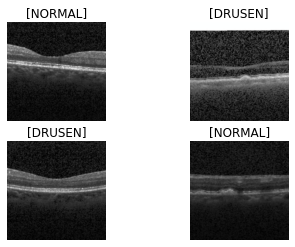

In [ ]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(type(labels))
            outputs = model(inputs)
            _, preds1 = torch.max(outputs, 1)
            for j in range(inputs.size()[1]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=batch_size)

Drawint the quntum circuit

In [ ]:
drawer = qml.draw(q_net)
q_in_example = np.random.rand(n_qubits)
q_weights_flat = np.random.rand(max_layers * n_qubits)
print(drawer(q_in_example, q_weights_flat))

 0: ──H──RY(0.946)──╭C───RY(0.703)─────────────╭C───RY(0.876)──────────────╭C───RY(0.918)─────────────╭C───RY(0.741)─────────────╭C───RY(0.213)───────────────╭C───RY(0.556)──────────────╭C───RY(0.567)─────────────╭C───RY(0.76)──────────────┤ ⟨Z⟩ 
 1: ──H──RY(0.984)──╰X──╭C──────────RY(0.978)──╰X──╭C───────────RY(0.414)──╰X──╭C──────────RY(0.142)──╰X──╭C──────────RY(0.797)──╰X──╭C───────────RY(0.0128)──╰X──╭C──────────RY(0.0014)──╰X──╭C──────────RY(0.222)──╰X──╭C──────────RY(0.433)──┤ ⟨Z⟩ 
 2: ──H──RY(0.783)──╭C──╰X──────────RY(0.302)──╭C──╰X───────────RY(0.443)──╭C──╰X──────────RY(0.415)──╭C──╰X──────────RY(0.167)──╭C──╰X───────────RY(0.891)───╭C──╰X──────────RY(0.609)───╭C──╰X──────────RY(0.135)──╭C──╰X──────────RY(0.552)──┤ ⟨Z⟩ 
 3: ──H──RY(0.419)──╰X───RY(0.199)─────────────╰X───RY(0.0653)─────────────╰X───RY(0.946)─────────────╰X───RY(0.78)──────────────╰X───RY(0.0397)──────────────╰X───RY(0.842)──────────────╰X───RY(0.921)─────────────╰X───RY(0.547)─────────────┤ ⟨Z⟩ 



Plotting the accuracy plot

In [ ]:
l_testing=[]
l_training=[]
for i in range(len(eval_accu1)):
  if(i%2!=0):
    l_testing.append(eval_accu1[i])
  else:
    l_training.append(eval_accu1[i])

In [ ]:
p=[i for i in range(1,21)]
#p = range(1,40)

In [ ]:
print(p)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(l_training)

20

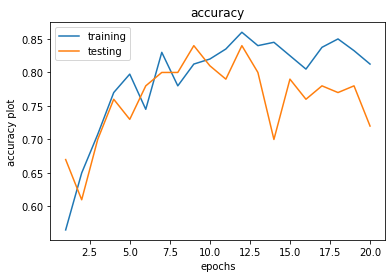

In [ ]:
plt.plot(p,l_training,label="training")
plt.plot(p,l_testing,label="testing")
plt.ylabel('accuracy plot')
plt.xlabel('epochs')
plt.title("accuracy")
plt.legend()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['DRUSEN', 'NORMAL']
print(classification_report(classes, preds, target_names=target_names))

              precision    recall  f1-score   support

      DRUSEN       0.67      1.00      0.80         2
      NORMAL       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

